In [68]:

## NLP
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import TweetTokenizer
from gensim.summarization import keywords # pip3 install gensim==3.6.0
#!pip install vaderSentiment
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## Deeplearning/ML
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow.keras.layers as L
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
#from wordcloud import WordCloud 
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns

import numpy as np 
import pandas as pd

import random as rn

In [2]:
data = pd.read_parquet(r"C:\Users\Student\Desktop\filter_trip_data",engine="fastparquet")
data.head()

,Hotel_Name,Total_Rating,Review_Text
0,Delfino Blu Wellness Boutique Hotel,5,We stayed for 7 nights at the end of September...
1,Delfino Blu Wellness Boutique Hotel,5,We were looking for a relaxing week in the sun...
2,Delfino Blu Wellness Boutique Hotel,5,We had been considering a trip here for some t...
3,Delfino Blu Wellness Boutique Hotel,5,The wonderful staff team quickly get to know a...
4,Delfino Blu Wellness Boutique Hotel,5,This is my first booking with this beautiful l...


In [3]:
data.isna().sum()

Hotel_Name      0
Total_Rating    0
Review_Text     0
dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2955405 entries, 0 to 2955404
Data columns (total 3 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   Hotel_Name    object
 1   Total_Rating  int64 
 2   Review_Text   object
dtypes: int64(1), object(2)
memory usage: 67.6+ MB


In [6]:
data1 = data[data["Total_Rating"] == 1]
data2 = data[data["Total_Rating"] == 2]
data3 = data[data["Total_Rating"] == 3]
data4 = data[data["Total_Rating"] == 4]
data5 = data[data["Total_Rating"] == 5]

In [7]:
print(data1.shape)
print(data2.shape)
print(data3.shape)
print(data4.shape)
print(data5.shape)

(187796, 3)
(210175, 3)
(439568, 3)
(854235, 3)
(1263631, 3)


In [8]:
from sklearn.utils import resample
data2_downsample = resample(data2,
             replace=True,
             n_samples=len(data1),
             random_state=42)

data3_downsample = resample(data3,
             replace=True,
             n_samples=len(data1),
             random_state=42)

data4_downsample = resample(data4,
             replace=True,
             n_samples=len(data1),
             random_state=42)

data5_downsample = resample(data5,
             replace=True,
             n_samples=len(data1),
             random_state=42)

print(data5_downsample.shape)

(187796, 3)


In [9]:
data_downsampled = pd.concat([data1, data2_downsample , data3_downsample , data4_downsample , data5_downsample])
data_downsampled.head()
data_downsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 938980 entries, 269 to 1143616
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Hotel_Name    938980 non-null  object
 1   Total_Rating  938980 non-null  int64 
 2   Review_Text   938980 non-null  object
dtypes: int64(1), object(2)
memory usage: 28.7+ MB


Data preprocessing

Label Encoding

In [10]:
X = data_downsampled['Review_Text'].copy()
y = data_downsampled['Total_Rating'].copy()

Tokenizing

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [12]:
X = tokenizer.texts_to_sequences(X)

max_length = max([len(x) for x in X])
vocab_size = len(tokenizer.word_index)+1

print("Vocabulary size: {}".format(vocab_size))
print("max length of sentence: {}".format(max_length))

Vocabulary size: 422992
max length of sentence: 6113


In [13]:
# Padding the reviews [Pads sequences to the same length.]
X = pad_sequences(X, padding='post', maxlen=350)#6113

In [15]:
encoding = {1: 0,
            2: 1,
            3: 2,
            4: 3,
            5: 4
           }

labels = ['1', '2', '3', '4', '5']

y = data_downsampled['Total_Rating'].copy()
y.replace(encoding, inplace=True)

Split data into train/test

In [16]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    X, y, test_size=.3, random_state=67, stratify=y)

print("Examples in train data: {}".format(len(train_texts)))
print("Examples in test data: {}".format(len(test_texts)))

Examples in train data: 657286
Examples in test data: 281694


In [17]:
train_texts

array([[    9,   594,    36, ...,     0,     0,     0],
       [    1,    80,     8, ...,     0,     0,     0],
       [    7,   153,   230, ...,     0,     0,     0],
       ...,
       [    1,    13,    11, ...,     0,     0,     0],
       [37872,   264,    19, ...,     2,    97,   922],
       [    7,    66,    82, ...,     0,     0,     0]])

Model building and training

In [40]:
embedding_dim =16
EPOCHS = 20
BATCH_SIZE = 64
units = 76
val_split = 0.12

Building a custom model

In [41]:
model = tf.keras.Sequential([
    L.Embedding(vocab_size, int(embedding_dim), input_length=X.shape[1]),
    L.Bidirectional(L.LSTM(int(units),return_sequences=True)),
    L.Conv1D(64,3),
    L.MaxPool1D(),
    L.Flatten(),
    L.Dropout(0.2),
    L.Dense(128, activation="relu"),
    L.Dropout(0.2),
    L.Dense(64, activation="relu"),
    L.Dropout(0.2),
    L.Dense(5, activation="softmax")
])

In [42]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True) # You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [43]:
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer='adam',metrics=['accuracy']
             )

Training history

In [44]:
history = model.fit(train_texts, train_labels, epochs=int(EPOCHS), validation_split=float(val_split), batch_size=int(BATCH_SIZE), verbose=2)

Epoch 1/20
9038/9038 - 6056s - loss: 0.8797 - accuracy: 0.6085 - val_loss: 0.8349 - val_accuracy: 0.6286 - 6056s/epoch - 670ms/step
Epoch 2/20
9038/9038 - 6498s - loss: 0.7823 - accuracy: 0.6584 - val_loss: 0.7937 - val_accuracy: 0.6508 - 6498s/epoch - 719ms/step
Epoch 3/20
9038/9038 - 6592s - loss: 0.7218 - accuracy: 0.6905 - val_loss: 0.8126 - val_accuracy: 0.6559 - 6592s/epoch - 729ms/step
Epoch 4/20
9038/9038 - 6620s - loss: 0.6541 - accuracy: 0.7274 - val_loss: 0.8083 - val_accuracy: 0.6630 - 6620s/epoch - 732ms/step
Epoch 5/20
9038/9038 - 6812s - loss: 0.5790 - accuracy: 0.7664 - val_loss: 0.8440 - val_accuracy: 0.6634 - 6812s/epoch - 754ms/step
Epoch 6/20
9038/9038 - 7443s - loss: 0.5033 - accuracy: 0.8013 - val_loss: 0.8960 - val_accuracy: 0.6627 - 7443s/epoch - 824ms/step
Epoch 7/20
9038/9038 - 7883s - loss: 0.4342 - accuracy: 0.8313 - val_loss: 1.0338 - val_accuracy: 0.6625 - 7883s/epoch - 872ms/step
Epoch 8/20
9038/9038 - 8322s - loss: 0.3780 - accuracy: 0.8551 - val_loss: 1

In [46]:
pred = model.predict(test_texts)
pred_final = np.argmax(pred,axis=-1)
np.savetxt("pred_final_total.csv",pred_final, delimiter=",")

Evaluating

In [47]:
from sklearn.metrics import accuracy_score
print('Accuracy: {}%'.format(round(accuracy_score(pred_final, test_labels)*100),2))

Accuracy: 65%


In [48]:
from sklearn.metrics import mean_squared_error
print("Root mean square error: {}".format(round(np.sqrt(mean_squared_error(pred_final,test_labels)),3)))

Root mean square error: 0.735


In [49]:
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error: {}".format(round(np.sqrt(mean_absolute_error(pred_final,test_labels)),3)))

Mean Absolute Error: 0.639


In [50]:
print(classification_report(test_labels, pred_final))

              precision    recall  f1-score   support

           0       0.75      0.66      0.70     56338
           1       0.59      0.67      0.63     56339
           2       0.60      0.60      0.60     56339
           3       0.59      0.55      0.57     56339
           4       0.72      0.77      0.74     56339

    accuracy                           0.65    281694
   macro avg       0.65      0.65      0.65    281694
weighted avg       0.65      0.65      0.65    281694



In [51]:
model.save("lstm_cleanliness_4.h5")

In [52]:
new_model = tf.keras.models.load_model('Ds_BiLSTM_4.h5')

# Check its architecture
new_model.summary()

OSError: No file or directory found at Ds_BiLSTM_4.h5

In [27]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [55]:
trainHistory=pd.DataFrame(history.history)
trainHistory.to_csv('TrainHistory_total.csv')

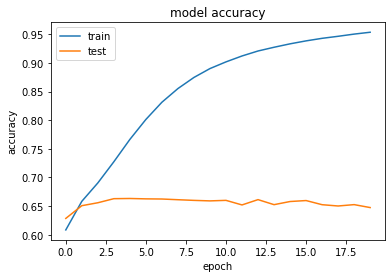

In [59]:
plt.plot(trainHistory['accuracy'])
plt.plot(trainHistory['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

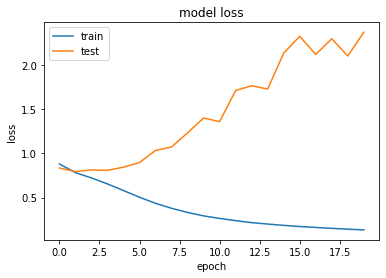

In [60]:
plt.plot(trainHistory['loss'])
plt.plot(trainHistory['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

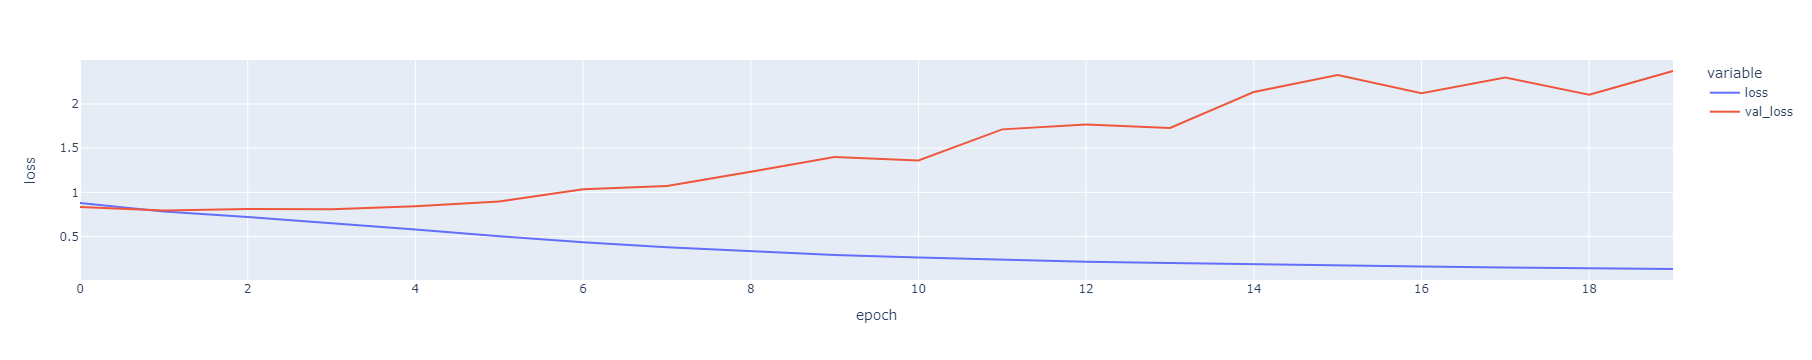

In [56]:
fig = px.line(
    trainHistory, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}
)

fig.show()

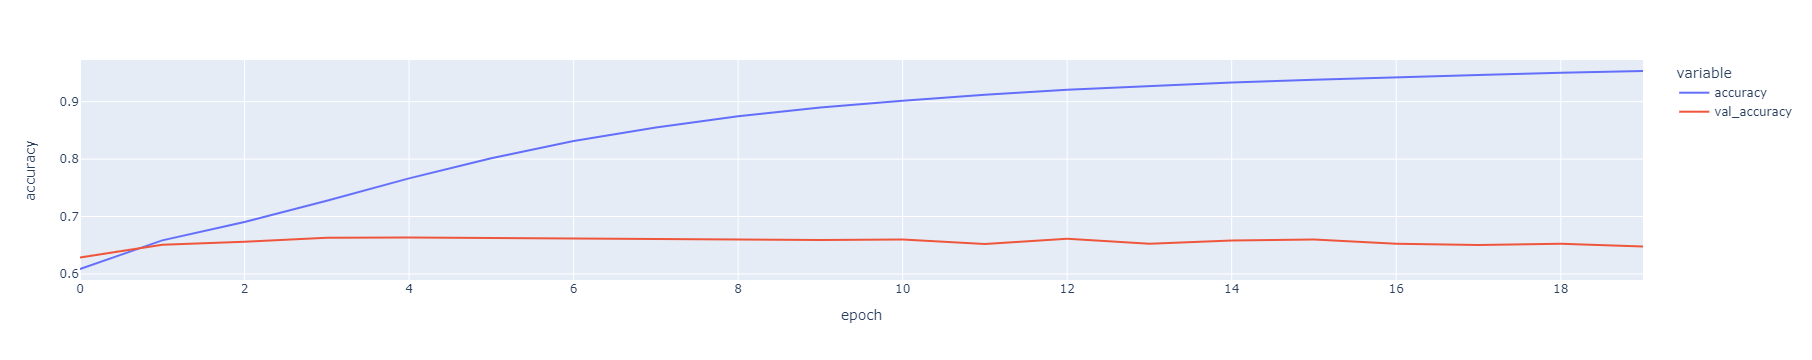

In [57]:
fig = px.line(
    trainHistory, y=['accuracy', 'val_accuracy'],
    labels={'index': 'epoch', 'value': 'accuracy'}
)

fig.show()

In [58]:
print('Confusion Matrix')
print(confusion_matrix(test_labels, pred_final))

Confusion Matrix
[[37210 14676  3716   474   262]
 [ 9284 37555  8181  1082   237]
 [ 2708  9365 33689  9109  1468]
 [  414  1356  8895 31000 14674]
 [  185   269  1472 11167 43246]]


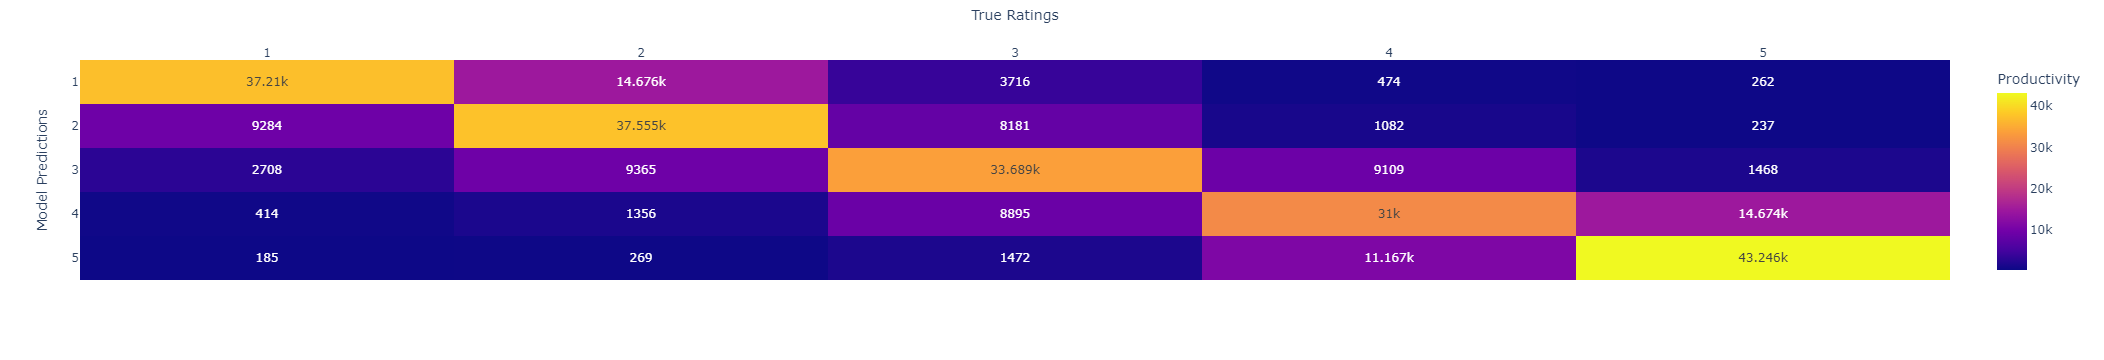

In [61]:
import plotly.express as px

fig = px.imshow(confusion_matrix(test_labels, pred_final), text_auto=True, aspect="auto",labels=dict(x="True Ratings", y="Model Predictions", color="Productivity"),
                x=['1', '2', '3', '4', '5'],
                y=['1', '2', '3','4','5']
               )

fig.update_xaxes(side="top")
fig.show()

In [62]:
df2 = pd.DataFrame(data = test_labels)

In [63]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281694 entries, 974144 to 2371257
Data columns (total 1 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   Total_Rating  281694 non-null  int64
dtypes: int64(1)
memory usage: 4.3 MB


In [64]:
print(test_labels)

974144     1
164288     4
1902207    4
1849949    3
191205     3
          ..
2563527    1
2384011    1
150314     3
2029141    4
2371257    0
Name: Total_Rating, Length: 281694, dtype: int64


In [65]:
df2["pred"]=pred_final

In [66]:
df2.head()

,Total_Rating,pred
974144,1,4
164288,4,4
1902207,4,2
1849949,3,2
191205,3,4


In [67]:
df2.to_csv("result_total.csv",index=False)